In [2]:
import os
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
from skimage import io, color
from skimage.filters import rank
from skimage.morphology import disk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

### Distribution of Class in Train test val dataset.

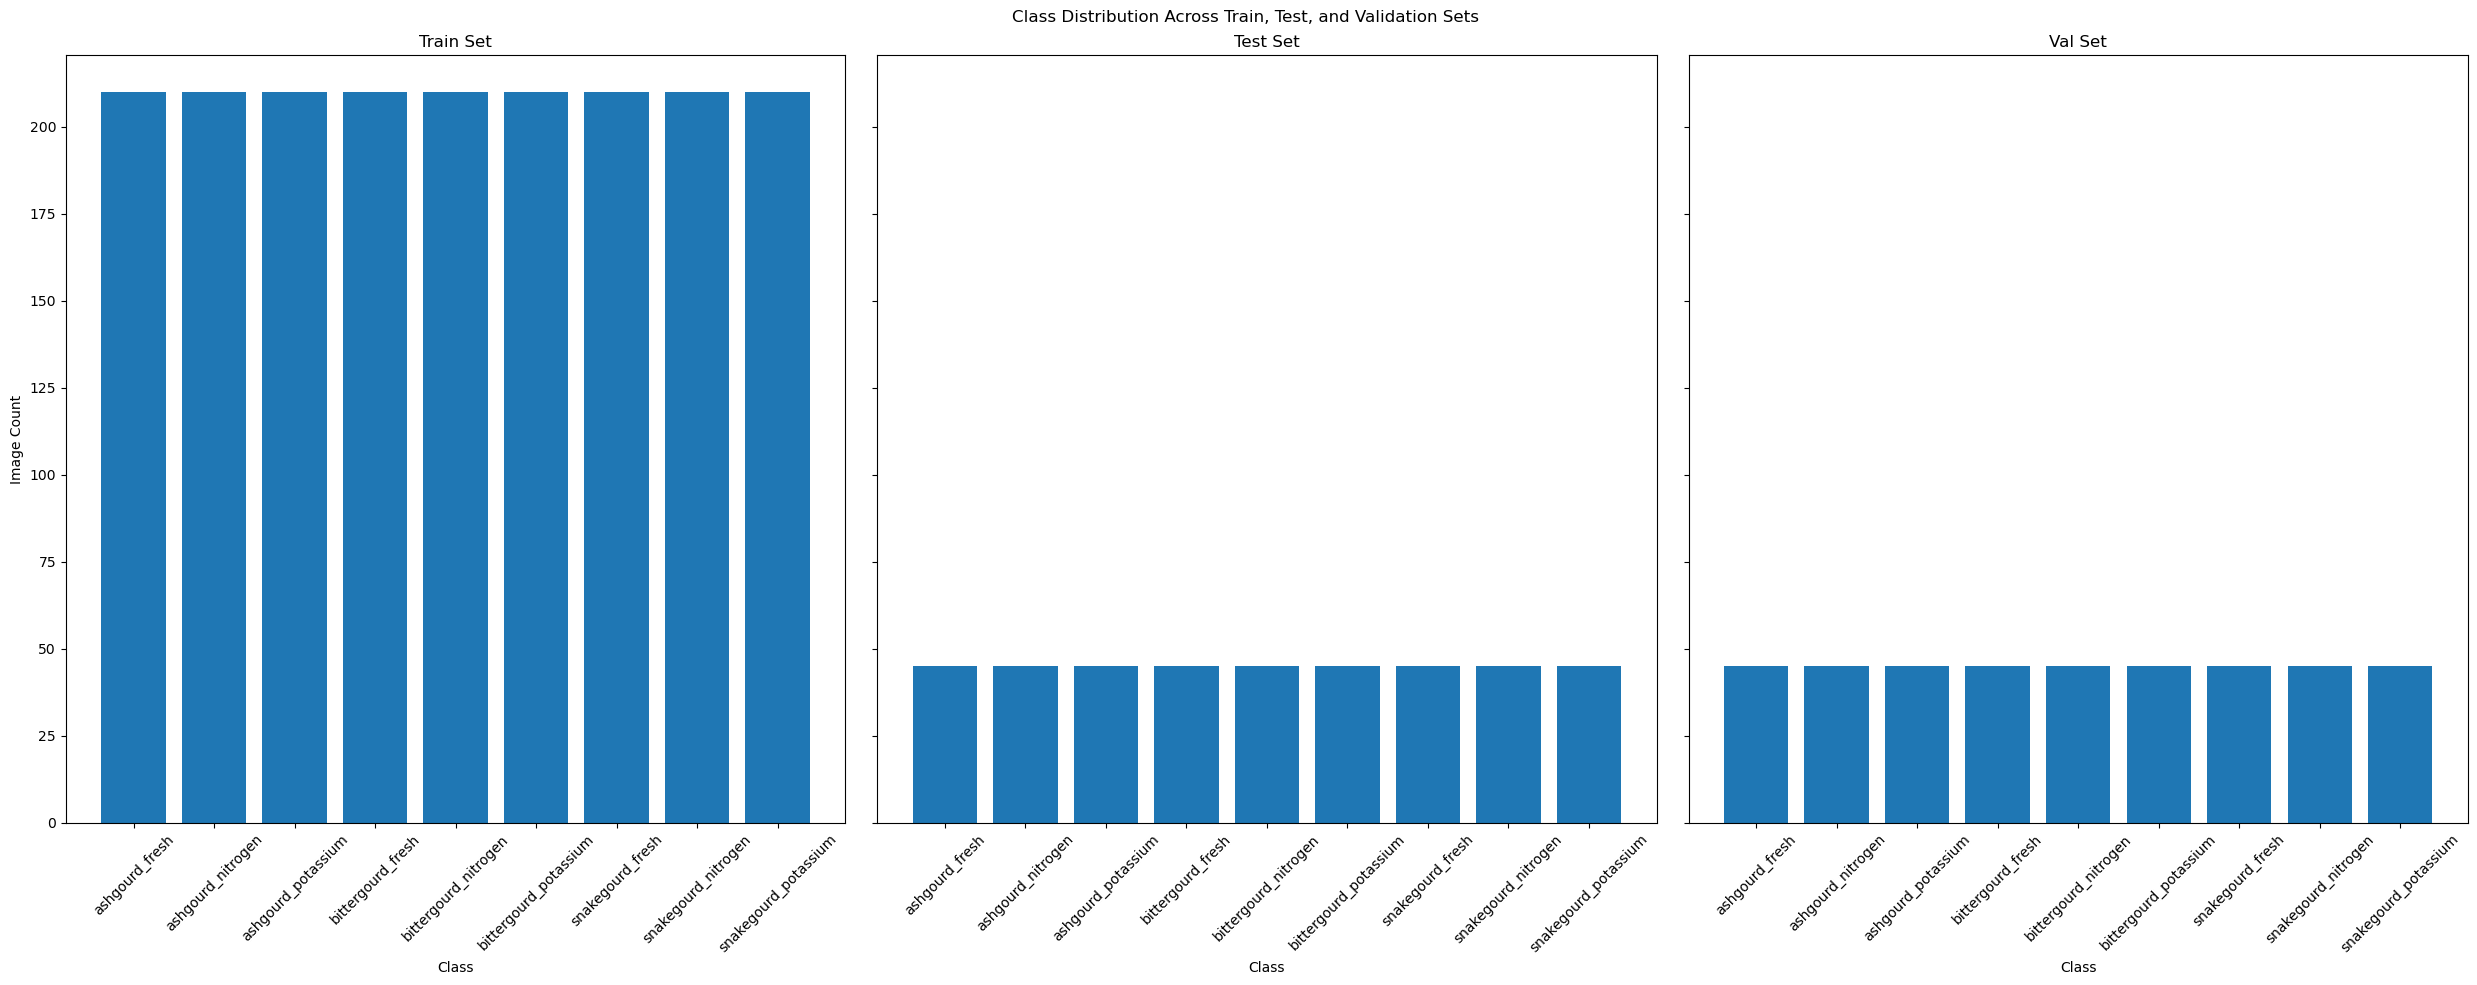

In [3]:
# Define the base directory
base_dir = r"C:\Users\ppt59\Desktop\working projects\Srija - Deep learning model for Early detection of plant nutritional deficiencies\Dataset"

# Function to count images in each class for train, test, and validation sets
def count_images_in_folders(base_dir):
    class_counts = defaultdict(lambda: defaultdict(int))
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_dir, split)
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_dir = os.path.join(split_path, class_name)
                if os.path.isdir(class_dir):
                    class_counts[split][class_name] = len(os.listdir(class_dir))
    return class_counts

# Get the class distribution
class_distribution = count_images_in_folders(base_dir)


fig, ax = plt.subplots(1, 3, figsize=(25, 10), sharey=True)

for idx, split in enumerate(['train', 'test', 'val']):
    class_counts = class_distribution.get(split, {})
    ax[idx].bar(class_counts.keys(), class_counts.values())
    ax[idx].set_title(f"{split.capitalize()} Set")
    ax[idx].set_xlabel("Class")
    ax[idx].set_ylabel("Image Count" if idx == 0 else "")
    ax[idx].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.suptitle("Class Distribution Across Train, Test, and Validation Sets")
plt.tight_layout()
plt.show()


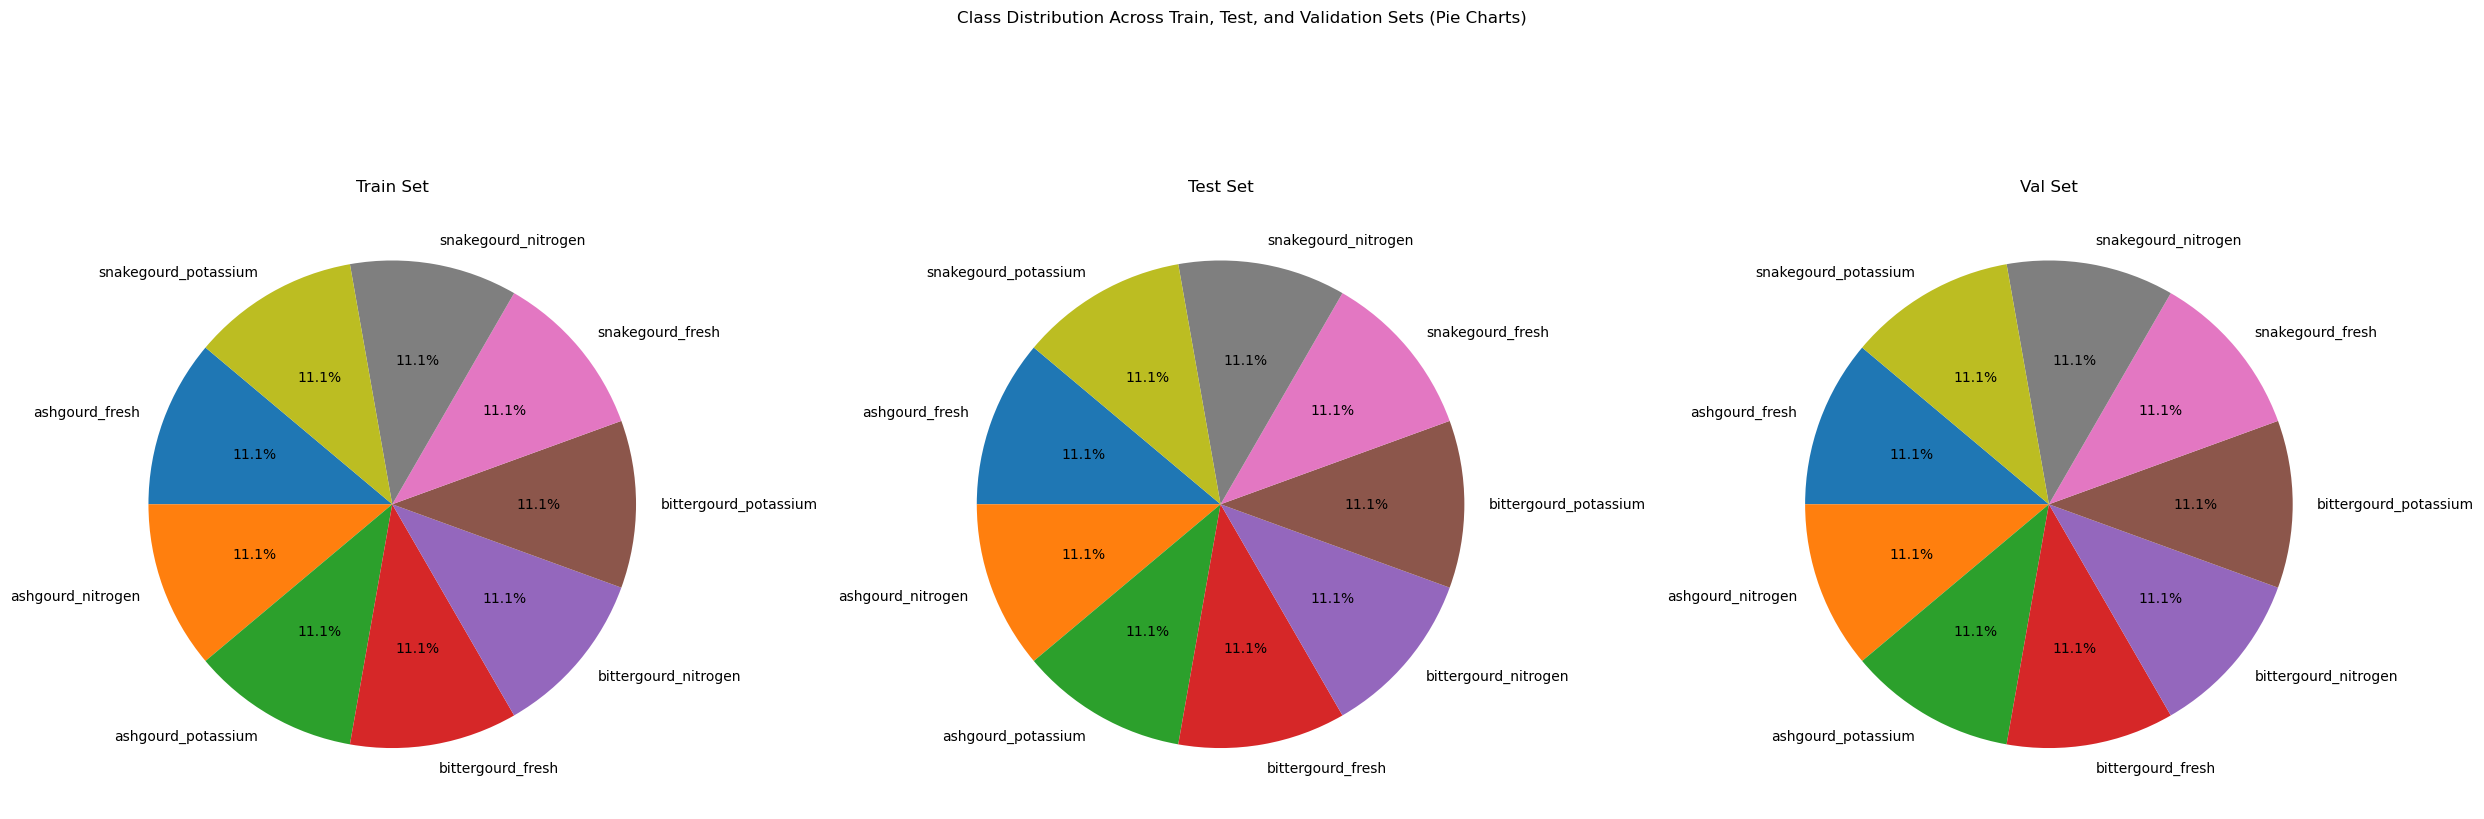

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

for idx, split in enumerate(['train', 'test', 'val']):
    class_counts = class_distribution.get(split, {})
    ax[idx].pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
    ax[idx].set_title(f"{split.capitalize()} Set")

plt.suptitle("Class Distribution Across Train, Test, and Validation Sets (Pie Charts)")
plt.tight_layout()
plt.show()

### Random Images display from the dataset

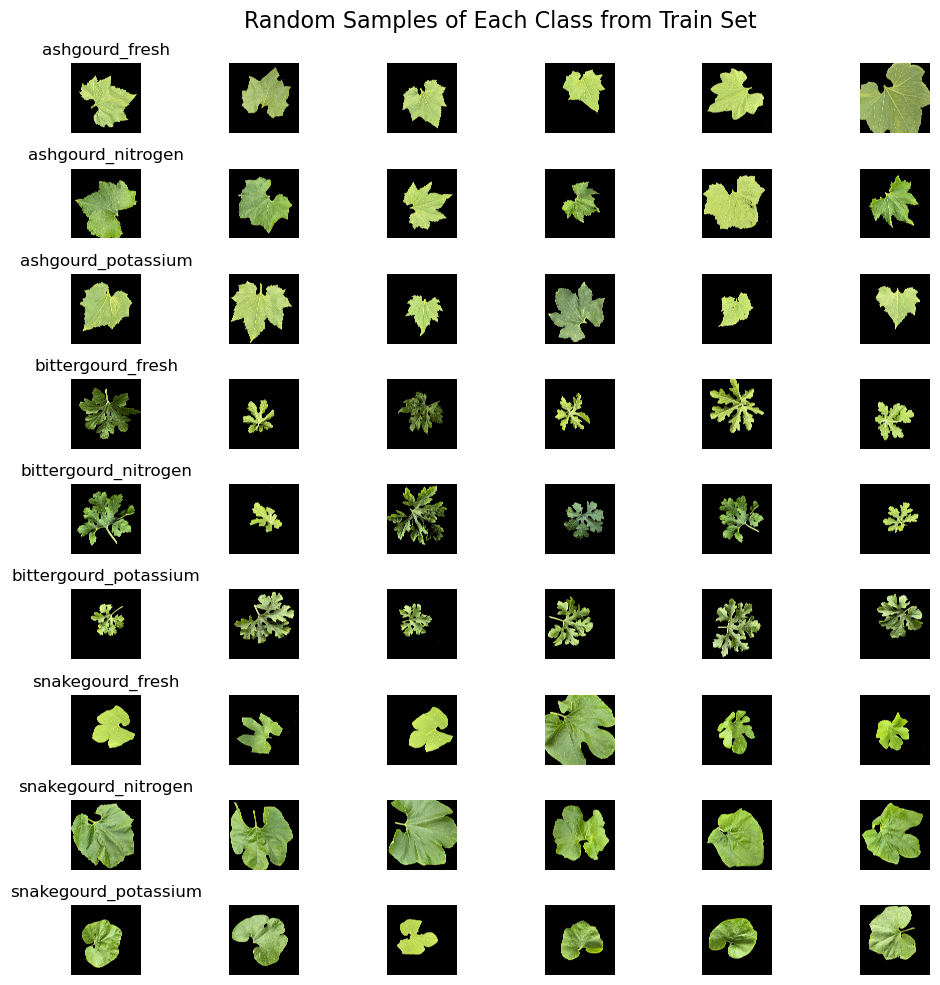

In [5]:
# Function to display random images from each class
def display_random_images(base_dir, num_images=6):
    # Increase the figsize to make images larger
    fig, axes = plt.subplots(len(class_distribution['train']), num_images, figsize=(10, 10))
    
    for idx, class_name in enumerate(class_distribution['train'].keys()):
        class_path = os.path.join(base_dir, 'train', class_name)
        image_files = os.listdir(class_path)
        sampled_images = random.sample(image_files, min(num_images, len(image_files)))
        
        for jdx, image_file in enumerate(sampled_images):
            img_path = os.path.join(class_path, image_file)
            img = Image.open(img_path)
            axes[idx, jdx].imshow(img)
            axes[idx, jdx].axis('off')
            if jdx == 0:
                axes[idx, jdx].set_title(class_name, fontsize=12)  # Optional: Set a font size for class titles
                
    plt.suptitle("Random Samples of Each Class from Train Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display random images from each class in the train set
display_random_images(base_dir)


### Images size distribution

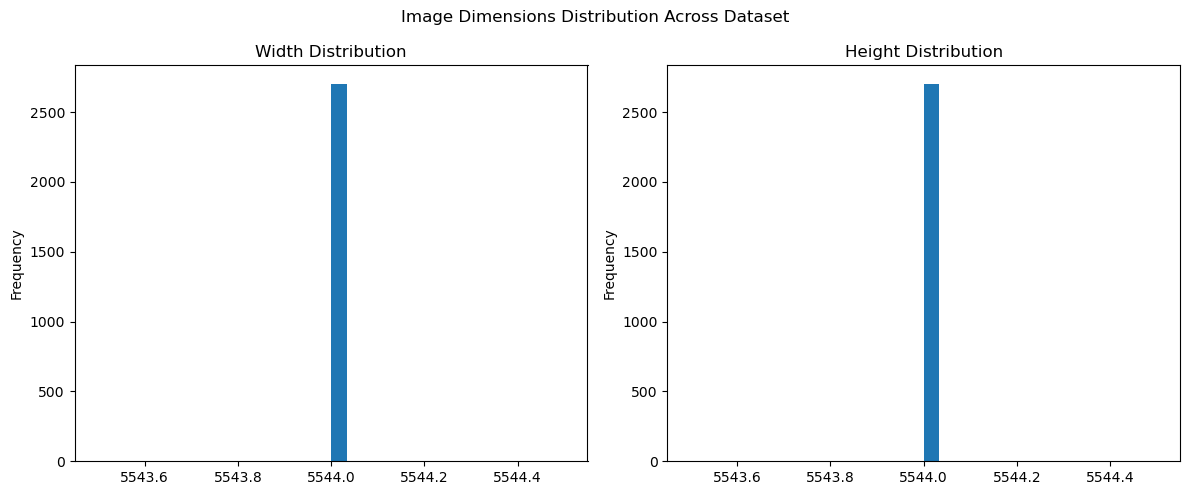

Width standard deviation: 0.0
Height standard deviation: 0.0
All images have the same dimensions. Reshaping may not be required.


In [5]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to gather image dimensions from a directory
def calculate_image_dimensions(base_dir):
    dimensions = defaultdict(list)
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_dir, split)
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_dir = os.path.join(split_path, class_name)
                if os.path.isdir(class_dir):
                    for image_file in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, image_file)
                        with Image.open(img_path) as img:
                            width, height = img.size
                            dimensions[split].append((width, height))
    return dimensions

# Calculate image dimensions
image_dimensions = calculate_image_dimensions(base_dir)

# Convert dimensions to a DataFrame for easier analysis
dimension_data = {'split': [], 'width': [], 'height': []}
for split, dims in image_dimensions.items():
    for (width, height) in dims:
        dimension_data['split'].append(split)
        dimension_data['width'].append(width)
        dimension_data['height'].append(height)

df = pd.DataFrame(dimension_data)

# Display the distribution of image dimensions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df['width'].plot(kind='hist', bins=30, ax=ax[0], title="Width Distribution")
df['height'].plot(kind='hist', bins=30, ax=ax[1], title="Height Distribution")
plt.suptitle("Image Dimensions Distribution Across Dataset")
plt.tight_layout()
plt.show()

# Check if reshaping is required
width_std_dev = df['width'].std()
height_std_dev = df['height'].std()
print(f"Width standard deviation: {width_std_dev}")
print(f"Height standard deviation: {height_std_dev}")

# Recommendation
if width_std_dev > 0 or height_std_dev > 0:
    print("Images have varying dimensions. Consider resizing them to a uniform shape (e.g., 224x224) for model consistency.")
else:
    print("All images have the same dimensions. Reshaping may not be required.")


### Image brightness and Contrast distribution

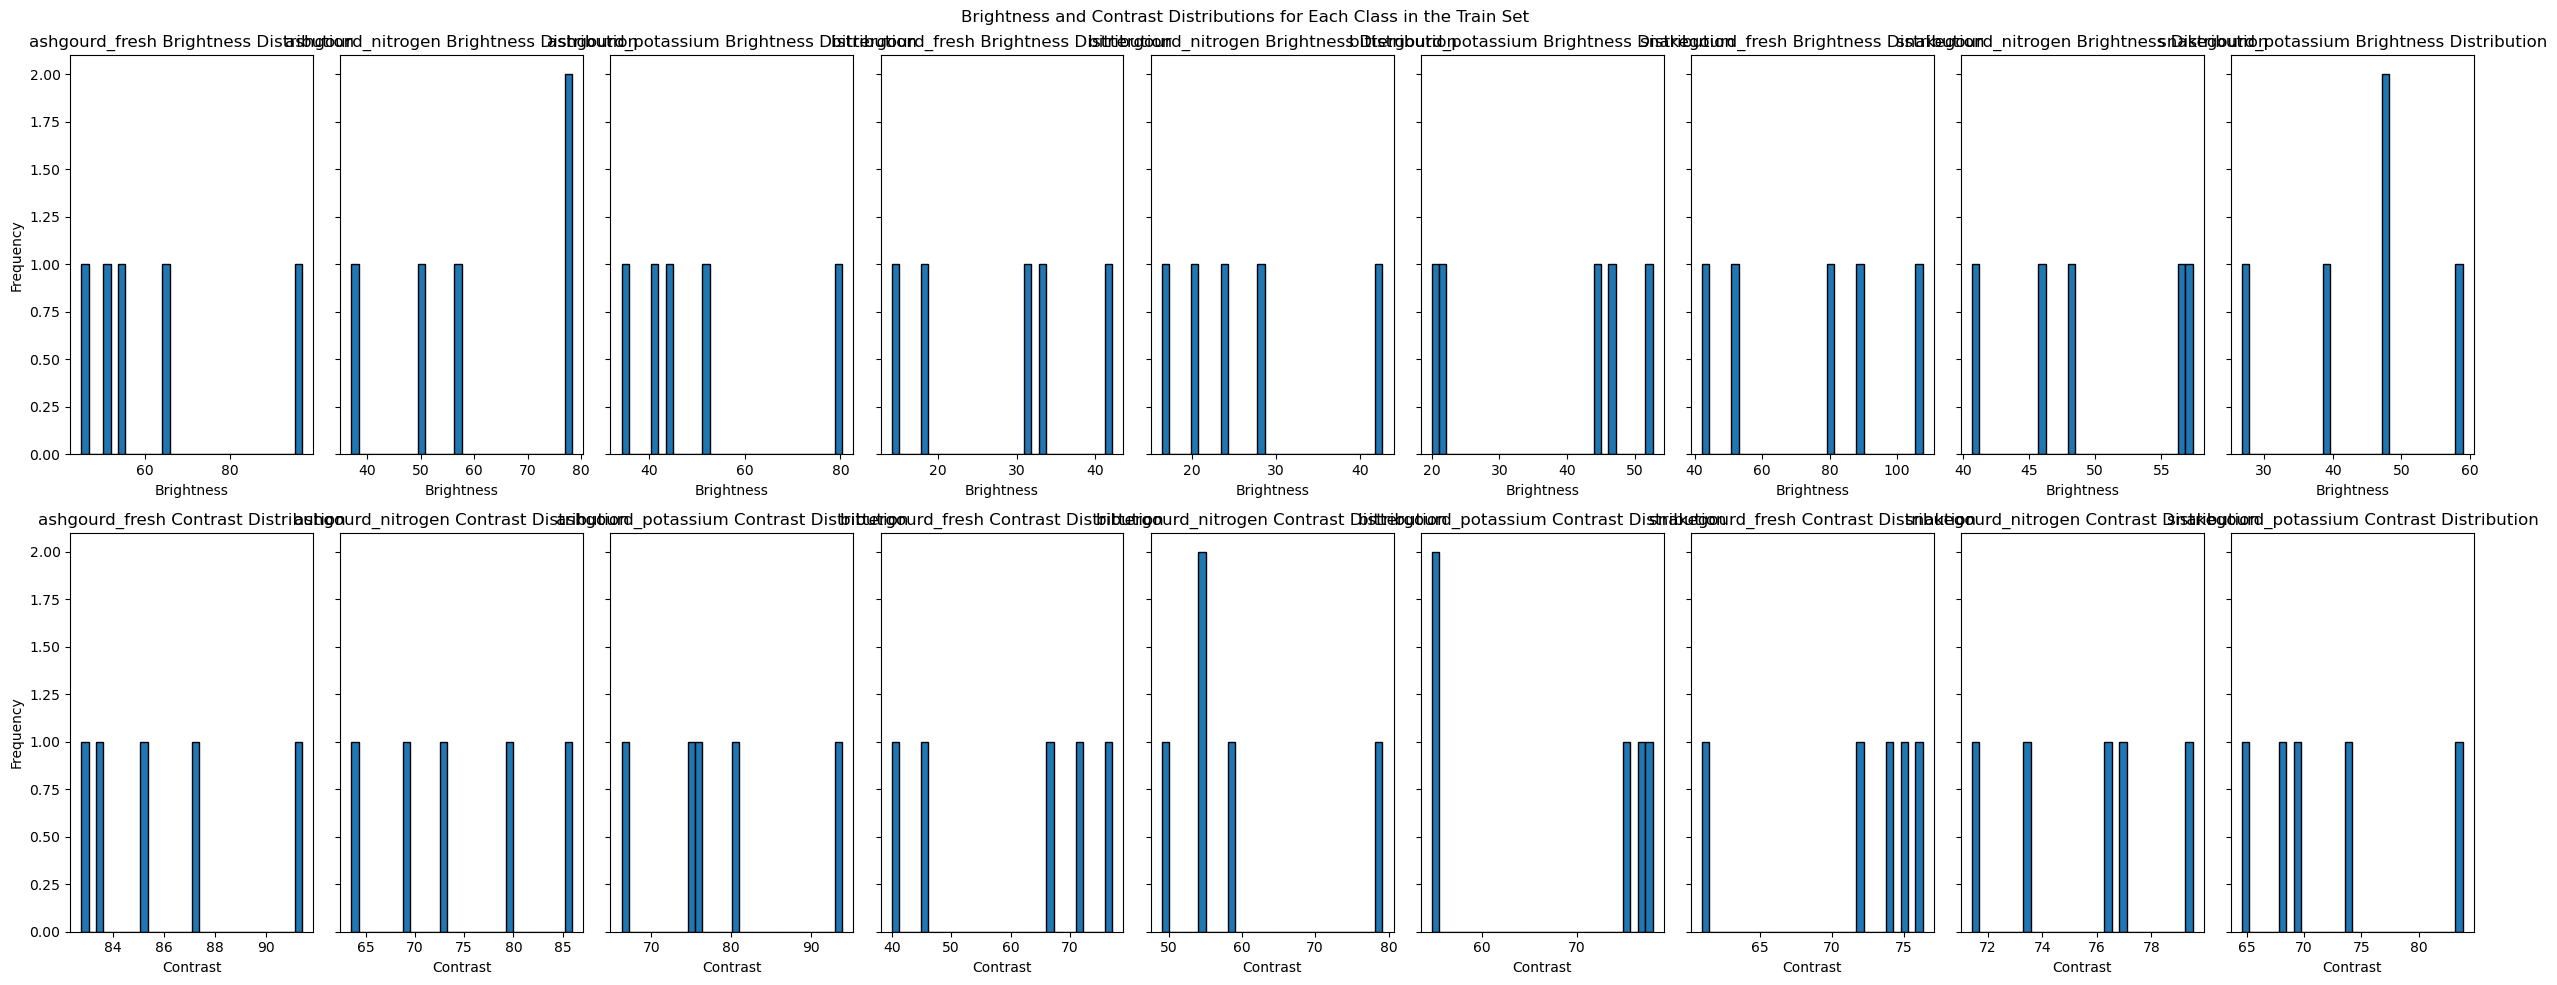

In [6]:
# Function to calculate brightness and contrast statistics for each class in the train set
def calculate_brightness_contrast_train(base_dir, num_images=5):
    brightness_contrast = defaultdict(lambda: {'brightness': [], 'contrast': []})
    
    train_path = os.path.join(base_dir, 'train')
    if os.path.exists(train_path):
        for class_name in os.listdir(train_path):
            class_path = os.path.join(train_path, class_name)
            if os.path.isdir(class_path):
                # Sample a limited number of images for efficiency
                image_files = os.listdir(class_path)
                sampled_images = random.sample(image_files, min(num_images, len(image_files)))
                
                for image_file in sampled_images:
                    img_path = os.path.join(class_path, image_file)
                    img = Image.open(img_path).convert("L")  # Convert to grayscale
                    
                    # Calculate brightness as the mean pixel intensity
                    stat = ImageStat.Stat(img)
                    brightness = stat.mean[0]
                    
                    # Calculate contrast as the standard deviation of pixel intensities
                    contrast = stat.stddev[0]
                    
                    # Store the values for each class
                    brightness_contrast[class_name]['brightness'].append(brightness)
                    brightness_contrast[class_name]['contrast'].append(contrast)
                        
    return brightness_contrast

# Calculate brightness and contrast for each class in the train set
brightness_contrast_train_data = calculate_brightness_contrast_train(base_dir)

# Plot brightness and contrast distributions for each class in the train set
fig, axes = plt.subplots(2, len(brightness_contrast_train_data), figsize=(25, 10), sharey='row')

for idx, (class_name, data) in enumerate(brightness_contrast_train_data.items()):
    # Brightness distribution
    axes[0, idx].hist(data['brightness'], bins=30, edgecolor='black')
    axes[0, idx].set_title(f"{class_name} Brightness Distribution")
    axes[0, idx].set_xlabel("Brightness")
    axes[0, idx].set_ylabel("Frequency" if idx == 0 else "")
    
    # Contrast distribution
    axes[1, idx].hist(data['contrast'], bins=30, edgecolor='black')
    axes[1, idx].set_title(f"{class_name} Contrast Distribution")
    axes[1, idx].set_xlabel("Contrast")
    axes[1, idx].set_ylabel("Frequency" if idx == 0 else "")

plt.suptitle("Brightness and Contrast Distributions for Each Class in the Train Set")
plt.tight_layout()
plt.show()


### Color channel analysis

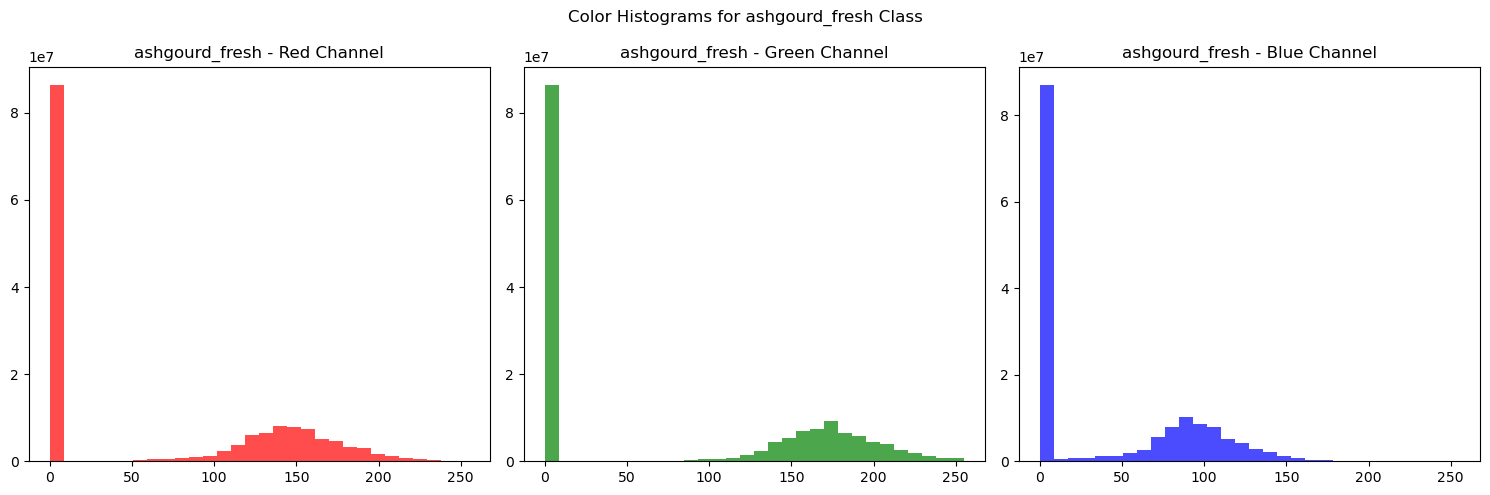

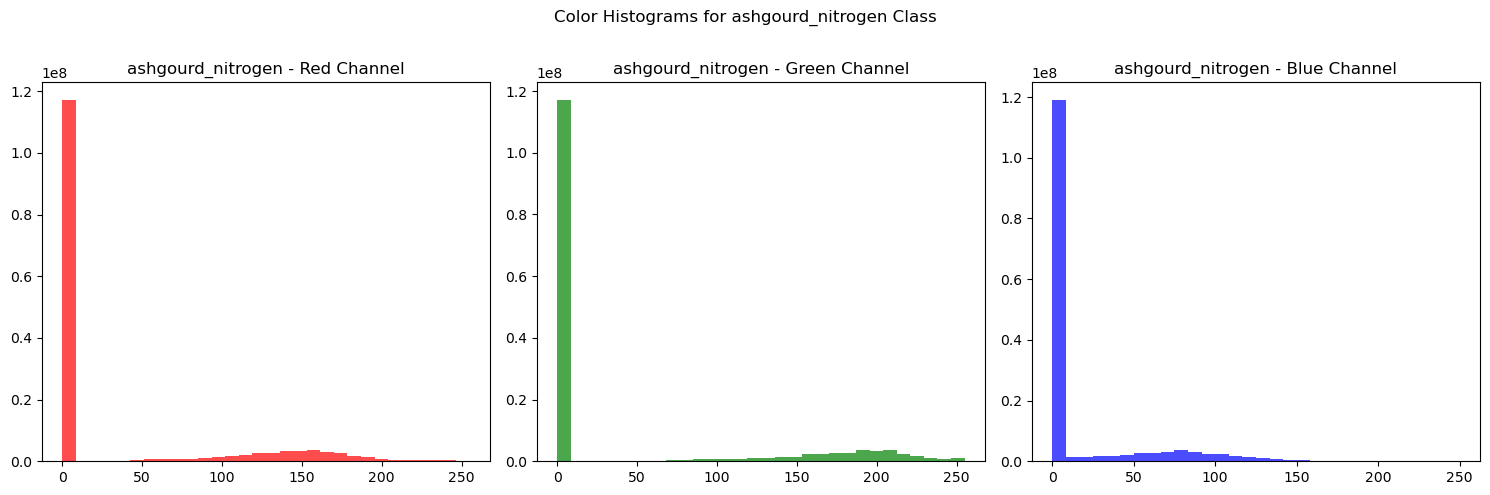

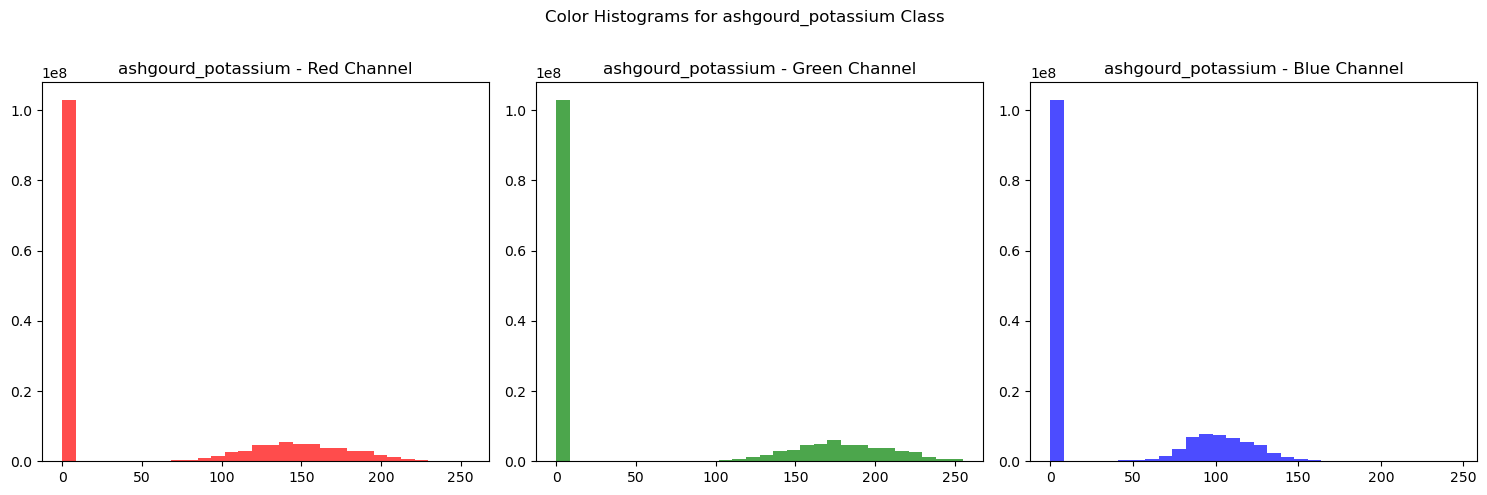

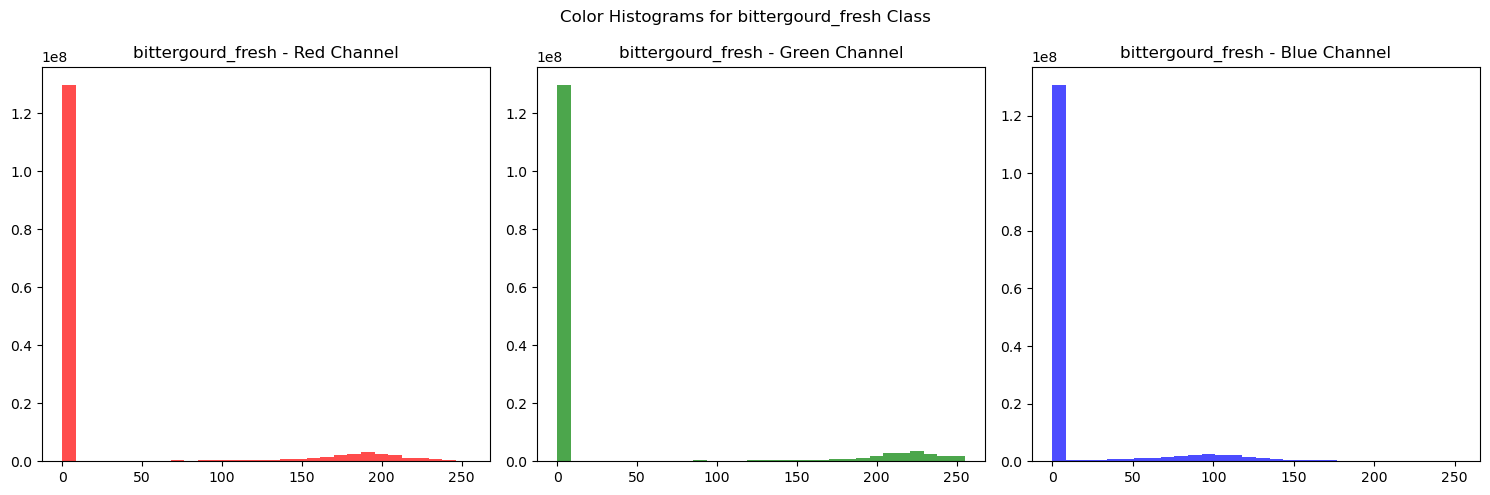

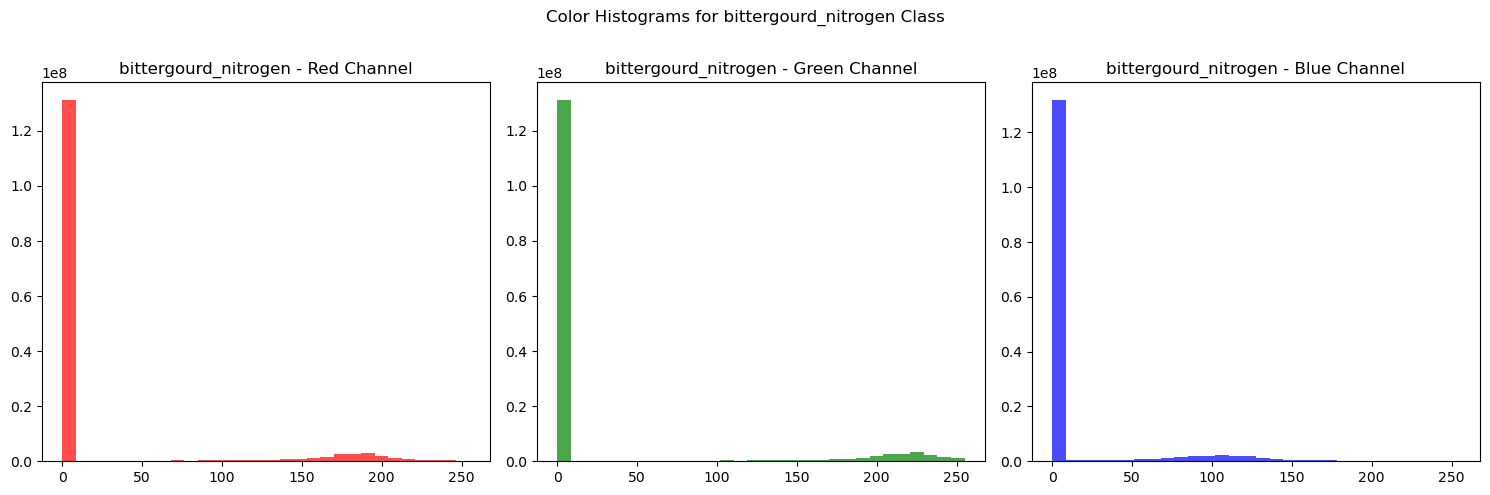

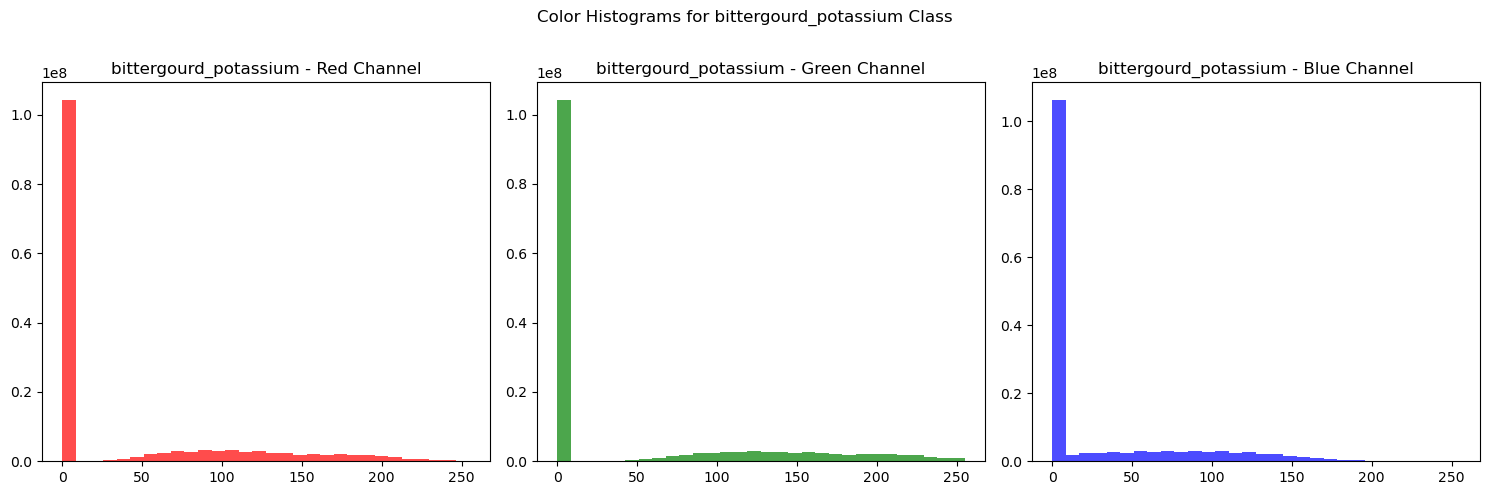

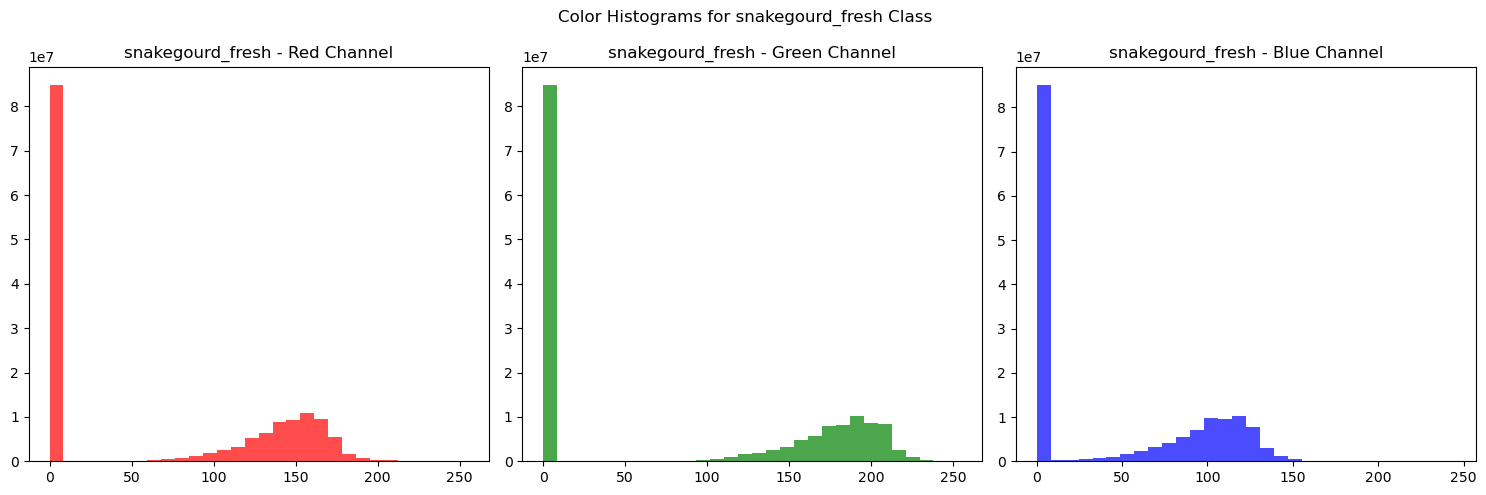

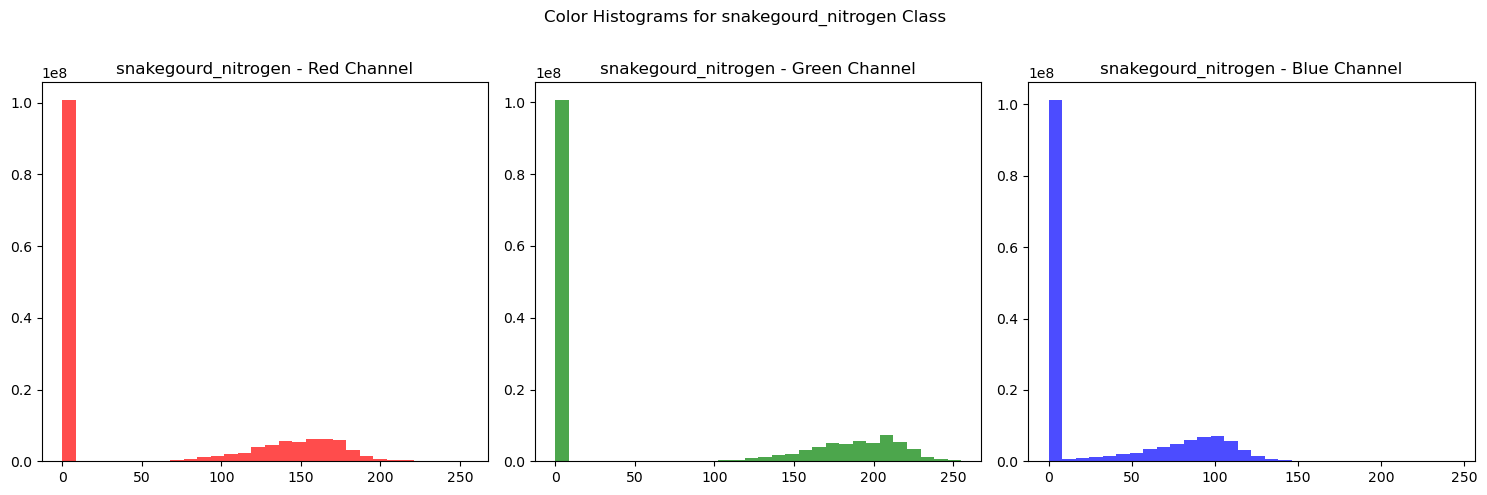

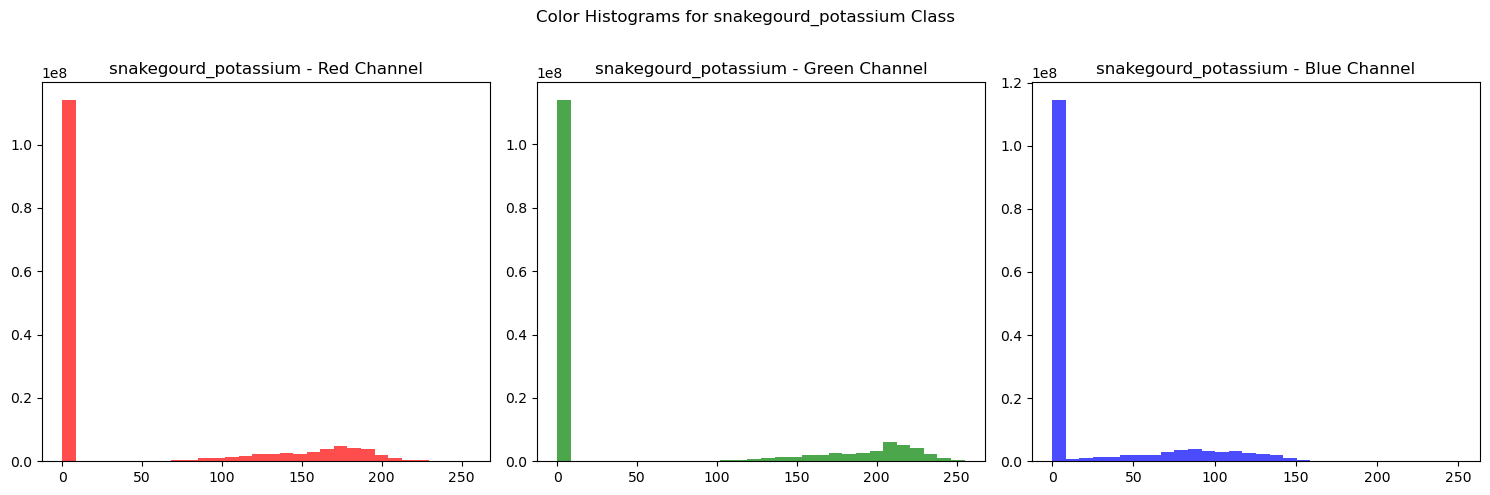

In [7]:
# Function to calculate RGB histograms for each class
def plot_rgb_histograms(base_dir, num_images=5):
    for class_name in os.listdir(os.path.join(base_dir, 'train')):
        class_path = os.path.join(base_dir, 'train', class_name)
        if os.path.isdir(class_path):
            # Sample a few images from each class
            image_files = os.listdir(class_path)
            sampled_images = image_files[:num_images]
            
            # Initialize lists to store RGB values
            reds, greens, blues = [], [], []
            
            for image_file in sampled_images:
                img_path = os.path.join(class_path, image_file)
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    # Separate RGB channels
                    r, g, b = img.split()
                    reds.extend(np.array(r).flatten())
                    greens.extend(np.array(g).flatten())
                    blues.extend(np.array(b).flatten())
            
            # Plot histograms for each color channel
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].hist(reds, bins=30, color='red', alpha=0.7)
            ax[0].set_title(f"{class_name} - Red Channel")
            ax[1].hist(greens, bins=30, color='green', alpha=0.7)
            ax[1].set_title(f"{class_name} - Green Channel")
            ax[2].hist(blues, bins=30, color='blue', alpha=0.7)
            ax[2].set_title(f"{class_name} - Blue Channel")
            
            plt.suptitle(f"Color Histograms for {class_name} Class")
            plt.tight_layout()
            plt.show()

# Generate RGB histograms for each class in the train set
plot_rgb_histograms(base_dir)

### Texture analysis

C:\Users\ppt59\AppData\Local\Temp\ipykernel_11796\2394589069.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy = rank.entropy(gray_img, disk(3)).mean()
C:\Users\ppt59\AppData\Local\Temp\ipykernel_11796\2394589069.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes, rotation=90)
C:\Users\ppt59\AppData\Local\Temp\ipykernel_11796\2394589069.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes, rotation=90)


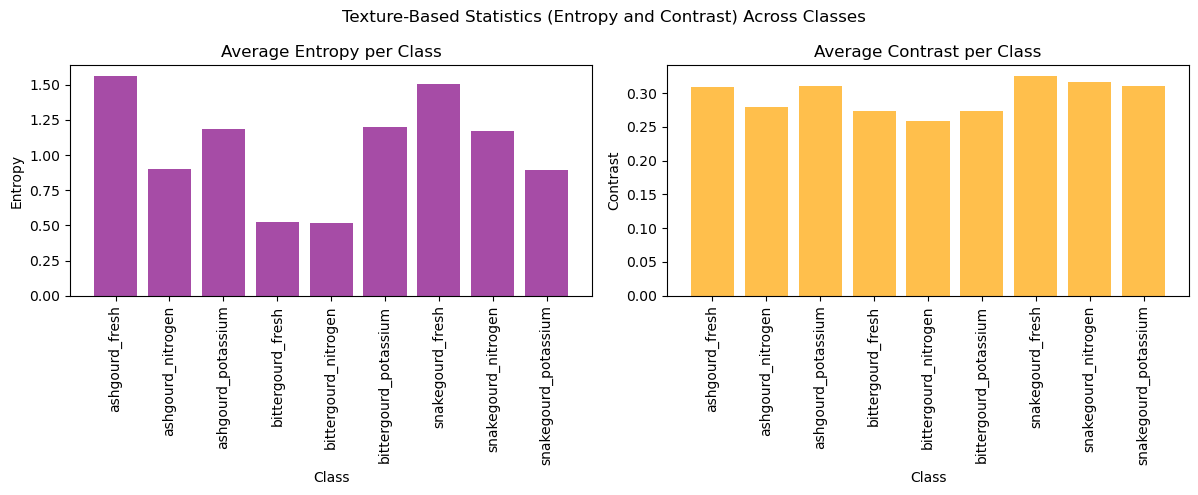

In [7]:
# Function to calculate entropy and contrast for images in each class
def calculate_texture_features(base_dir, num_images=5):
    texture_stats = defaultdict(lambda: {'entropy': [], 'contrast': []})
    
    for class_name in os.listdir(os.path.join(base_dir, 'train')):
        class_path = os.path.join(base_dir, 'train', class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            sampled_images = image_files[:num_images]
            
            for image_file in sampled_images:
                img_path = os.path.join(class_path, image_file)
                img = io.imread(img_path)
                
                # Convert to grayscale for texture analysis
                gray_img = color.rgb2gray(img)
                
                # Calculate entropy and contrast
                entropy = rank.entropy(gray_img, disk(3)).mean()
                contrast = gray_img.std()
                
                texture_stats[class_name]['entropy'].append(entropy)
                texture_stats[class_name]['contrast'].append(contrast)
    
    return texture_stats

# Calculate texture features
texture_features = calculate_texture_features(base_dir)

# Plot texture statistics for each class
classes = texture_features.keys()
avg_entropy = [np.mean(texture_features[cls]['entropy']) for cls in classes]
avg_contrast = [np.mean(texture_features[cls]['contrast']) for cls in classes]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot average entropy
ax[0].bar(classes, avg_entropy, color='purple', alpha=0.7)
ax[0].set_title("Average Entropy per Class")
ax[0].set_ylabel("Entropy")
ax[0].set_xlabel("Class")
ax[0].set_xticklabels(classes, rotation=90)

# Plot average contrast
ax[1].bar(classes, avg_contrast, color='orange', alpha=0.7)
ax[1].set_title("Average Contrast per Class")
ax[1].set_ylabel("Contrast")
ax[1].set_xlabel("Class")
ax[1].set_xticklabels(classes, rotation=90)

plt.suptitle("Texture-Based Statistics (Entropy and Contrast) Across Classes")
plt.tight_layout()
plt.show()


### Feature Clustering

C:\Users\ppt59\AppData\Local\Temp\ipykernel_2416\3273331044.py:25: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy = rank.entropy(gray_img, disk(3)).mean()
C:\Users\ppt59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ppt59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


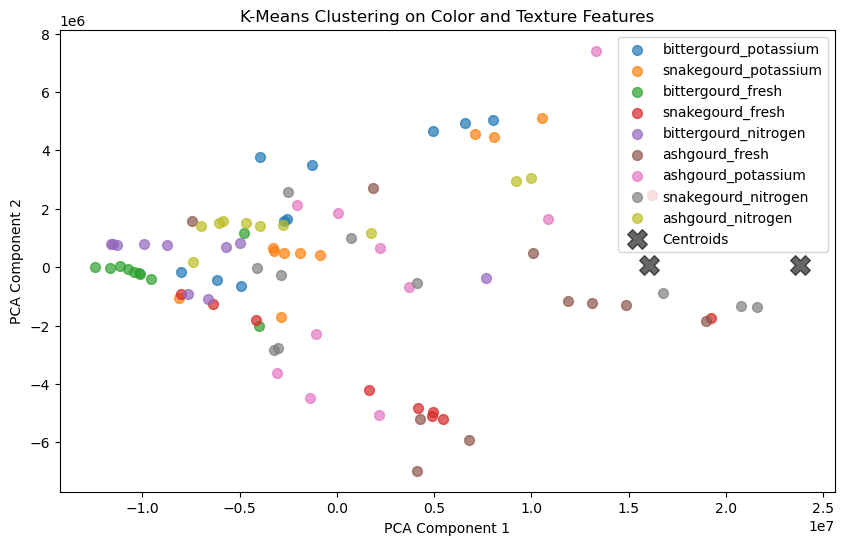

In [9]:
# Function to extract color and texture features
def extract_features(base_dir, num_images=10):
    features = []
    labels = []
    
    for class_name in os.listdir(os.path.join(base_dir, 'train')):
        class_path = os.path.join(base_dir, 'train', class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            sampled_images = image_files[:num_images]
            
            for image_file in sampled_images:
                img_path = os.path.join(class_path, image_file)
                img = io.imread(img_path)
                
                # Convert to grayscale for texture features
                gray_img = color.rgb2gray(img)
                
                # Calculate color histograms (using 10 bins per channel)
                r_hist, _ = np.histogram(img[:, :, 0], bins=10, range=(0, 256))
                g_hist, _ = np.histogram(img[:, :, 1], bins=10, range=(0, 256))
                b_hist, _ = np.histogram(img[:, :, 2], bins=10, range=(0, 256))
                
                # Calculate texture features (entropy and contrast)
                entropy = rank.entropy(gray_img, disk(3)).mean()
                contrast = gray_img.std()
                
                # Combine color histograms and texture features into one feature vector
                feature_vector = np.hstack([r_hist, g_hist, b_hist, entropy, contrast])
                features.append(feature_vector)
                labels.append(class_name)
                
    return np.array(features), labels

# Extract features
features, labels = extract_features(base_dir)

# Perform dimensionality reduction with PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features)

# Plot clustering results
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(set(labels)):
    idx = [j for j, label in enumerate(labels) if label == class_name]
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=class_name, s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=200, alpha=0.6, marker='X', label='Centroids')
plt.title("K-Means Clustering on Color and Texture Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()
